## Infinite Impulse Response (IIR) Filters (Remixed)

In [1]:
def sample_poles(filter_order):
    """
    Systems represented by stable right-sided sequences have all poles located within the unit circle, which suggests all eigenvalues of the system have magnitude less than one and thus state variables decay over time.
    """
    centerX = centerY = 0
    R = 1
    z = [0] * filter_order
    p = []
    for _ in range(filter_order // 2):
        r = R * np.sqrt(np.random.rand())
        theta = np.random.rand() * 2 * np.pi
        x = centerX + r * np.cos(theta)
        y = centerY + r * np.sin(theta)
        t = x + y * 1j

        p.append(t)
        p.append(t.conjugate())

    if filter_order%2 == 1:
        p.append(np.random.rand())
    return z, p

def create_gaussian_signal(seq_len, b, a):
    """
    Filter gaussian noise throught the IIR filter designed via Pole-sampling
    """
    xn = np.random.normal(0, 1, size=seq_len)
    x = np.tanh(signal.lfilter(b, a, xn))
    return xn, x

# Create input and output of shape (batch_size x seq_len x input_dims) 
def create_dataset(batch_size, seq_len, b, a):
    X = []
    Y = []
    for _ in range(batch_size):
        xn, x = create_gaussian_signal(seq_len, b, a)
        X.append(xn)
        Y.append(x)
            
    X = np.array(X)
    X = np.swapaxes(X, 0, 1)
    X = np.expand_dims(X, axis=2)

    Y = np.array(Y)
    Y = np.swapaxes(Y, 0, 1)
    Y = np.expand_dims(Y, axis=2)

    return X, Y

In [2]:
import numpy as np
import scipy.signal as signal

# Set Parameters
filter_order = N = 5
hidden_size = 5

seq_len = 150
wash_out = 50
batch_size = 100
split_ratio = 0.8

# Generate Data
z, p = sample_poles(filter_order)
b, a = signal.zpk2tf(z, p, 1)

X, Y = create_dataset(batch_size, seq_len, b, a)

split_index = int(split_ratio*batch_size)
train_X, train_Y = X[:,:split_index,:], Y[:,:split_index,:]
test_X, test_Y = X[:,split_index:,:], Y[:,split_index:,:]

## Visualize the Response
### Impulse Response

In [3]:
import matplotlib.pyplot as plt
from matplotlib import rc

# Set the global font to be DejaVu Sans, size 10 (or any other sans-serif font of your choice!)
rc('font',**{'family':'sans-serif','sans-serif':['DejaVu Sans'],'size':10})

# Set the font used for MathJax - more on this later
rc('mathtext',**{'default':'regular'})

%matplotlib inline

# The following %config line changes the inline figures to have a higher DPI.
# You can comment out (#) this line if you don't have a high-DPI (~220) display.
%config InlineBackend.figure_format = 'retina'

In [4]:
def stylize_axes(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(axis="x", direction="in")
    ax.tick_params(axis="y", direction="in")

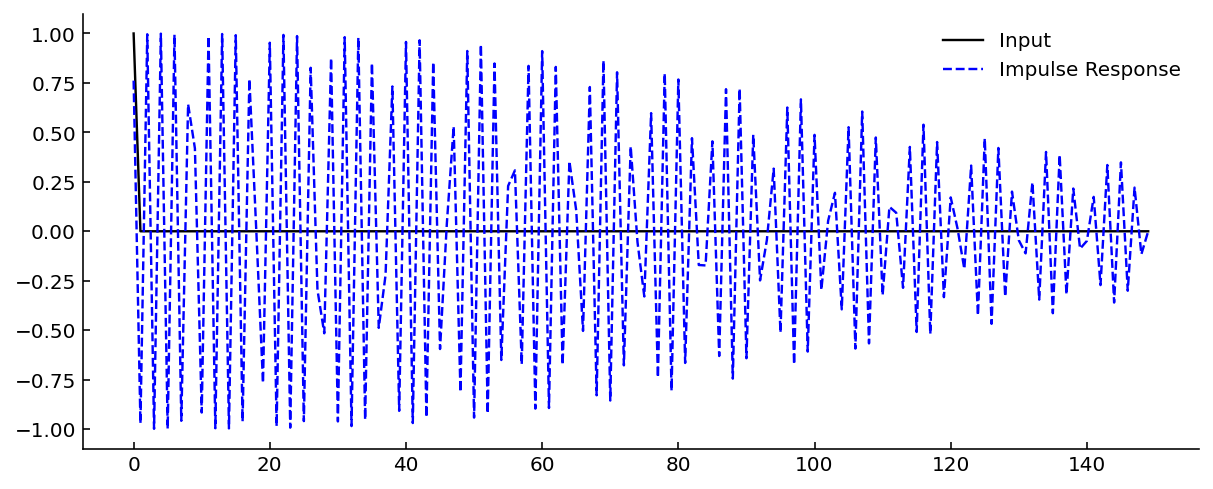

In [5]:
input = signal.unit_impulse(seq_len)
output = np.tanh(signal.lfilter(b, a, input))

fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(111)
stylize_axes(ax)
ax.plot(input, label="Input", color="black", linewidth=1.2)
ax.plot(output, label="Impulse Response", color="blue", linestyle="--", linewidth=1.2)
ax.legend(loc="upper right", frameon=False)
plt.show()

### Gaussian Noise

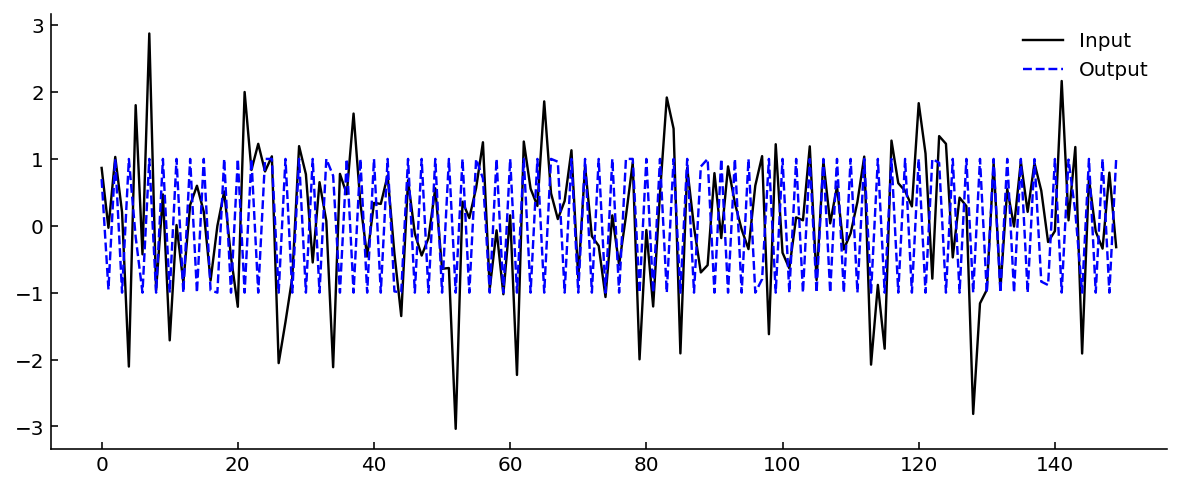

In [6]:
input = np.random.normal(0, 1, size=seq_len)
output = np.tanh(signal.lfilter(b, a, input))

fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(111)
stylize_axes(ax)
ax.plot(input, label="Input", color="black", linewidth=1.2)
ax.plot(output, label="Output", color="blue", linestyle="--", linewidth=1.2)
ax.legend(loc="upper right", frameon=False)
plt.show()

## Define Recurrent Neural Network Model


In [7]:
import torch
from torch import nn

class RNNLayer(nn.Module):
    """Linear RNN.

    Parameters:
        input_size: Number of input neurons
        hidden_size: Number of hidden neurons

    Inputs:
        input: tensor of shape (seq_len, batch, input_size)
        hidden: tensor of shape (batch, hidden_size), initial hidden activity
                if None, hidden is initialized through self.init_hidden()
        
    Outputs:
        output: tensor of shape (seq_len, batch, hidden_size)
        hidden: tensor of shape (batch, hidden_size), final hidden activity
    """

    def __init__(self, input_size, hidden_size, **kwargs):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size, hidden_size, bias=False)
        self.h2h = nn.Linear(hidden_size, hidden_size, bias=False)

    def init_hidden(self, input_shape):
        batch_size = input_shape[1]
        return torch.zeros(batch_size, self.hidden_size)

    def recurrence(self, input, hidden):
        """Run network for one time step.
        
        Inputs:
            input: tensor of shape (batch, input_size)
            hidden: tensor of shape (batch, hidden_size)
        
        Outputs:
            h_new: tensor of shape (batch, hidden_size),
                network activity at the next time step
        """
        h_new = torch.tanh(self.i2h(input) + self.h2h(hidden))
        return h_new

    def forward(self, input, hidden=None):
        """Propogate input through the network."""
        
        # If hidden activity is not provided, initialize it
        if hidden is None:
            hidden = self.init_hidden(input.shape).to(input.device)

        # Loop through time
        output = []
        steps = range(input.size(0))
        for i in steps:
            hidden = self.recurrence(input[i], hidden)
            output.append(hidden)

        # Stack together output from all time steps
        output = torch.stack(output, dim=0)
        return output, hidden


class RNNNet(nn.Module):
    """Recurrent network model.

    Parameters:
        input_size: int, input size
        hidden_size: int, hidden size
        output_size: int, output size
    
    Inputs:
        x: tensor of shape (Seq Len, Batch, Input size)

    Outputs:
        out: tensor of shape (Seq Len, Batch, Output size)
        rnn_output: tensor of shape (Seq Len, Batch, Hidden size)
    """
    def __init__(self, input_size, hidden_size, output_size, **kwargs):
        super().__init__()

        self.rnn = RNNLayer(input_size, hidden_size, **kwargs)
        self.fc = nn.Linear(hidden_size, output_size, bias=False)

    def forward(self, x):
        rnn_output, _ = self.rnn(x)
        out = self.fc(rnn_output)
        return out, rnn_output

In [8]:
import math
import cmath
import matplotlib.pyplot as plt

def polar_plot(real_poles, imag_poles, realW_filter, imagW_filter, realW_bptt, imagW_bptt):
    fig = plt.figure(figsize=(15,15))

    theta, r = [], []
    for i,j in zip(real_poles, imag_poles):
        if not math.isnan(i) and not math.isnan(i):
            r_c, theta_c = cmath.polar(complex(i, j))
            r.append(r_c)
            theta.append(theta_c)
    
    r_filter, theta_filter = [], []
    for i,j in zip(realW_filter, imagW_filter):
        if not math.isnan(i) and not math.isnan(i):
            r_c, theta_c = cmath.polar(complex(i, j))
            r_filter.append(r_c)
            theta_filter.append(theta_c)

    r_bptt, theta_bptt = [], []
    for i,j in zip(realW_bptt, imagW_bptt):
        if not math.isnan(i) and not math.isnan(i):
            r_c, theta_c = cmath.polar(complex(i, j))
            r_bptt.append(r_c)
            theta_bptt.append(theta_c)

    ax = fig.add_subplot(121, projection='polar')
    ax.scatter(theta, r, color='black', marker='x', label='Poles')
    ax.scatter(theta_filter, r_filter, color='blue', marker='.', label='Filter Eigenvalues')
    ax.scatter(theta_bptt, r_bptt, color='red', marker='.', label='RNN Eigenvalues')
    # ax.set_rmax(1)
    # ax.set_rticks([0.25, 0.5, 0.75, 1])    # Less radial ticks
    # ax.set_rlabel_position(-22.5)          # Move radial labels away from plotted line
    ax.grid(True)
    ax.legend(bbox_to_anchor=(1.2, -0.05), loc="center right", frameon=False)
    plt.show()  

In [9]:
from matplotlib.animation import FuncAnimation

def return_polar_form(real, imag):
    r, theta = [], []
    for i,j in zip(real,imag):
        r_c, theta_c = cmath.polar(complex(i, j))
        r.append(r_c)
        theta.append(theta_c)
    return theta, r

def plot_polar_animation(real_poles, imag_poles, realW_filter, imagW_filter, realW_bptt, imagW_bptt, frames):
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(projection='polar')

    sc_poles = ax.scatter(*return_polar_form(real_poles, imag_poles), color='black', marker='x', label='Poles')
    sc_filter = ax.scatter([], [], color='blue', marker='.', label='Filter Eigenvalues')
    sc_bptt = ax.scatter([], [], color='red', marker='.', label='RNN Eigenvalues')

    # Update the frames based on the parameter i
    def animate(i):
        fig.suptitle(f'Epoch {i}')
        theta_filter, r_filter = return_polar_form(realW_filter[i], imagW_filter[i])
        sc_filter.set_offsets(np.c_[theta_filter, r_filter])

        theta, r = return_polar_form(realW_bptt[i], imagW_bptt[i])
        sc_bptt.set_offsets(np.c_[theta, r])
    
    ax.set_rmax(1)
    ax.set_rticks([0.25, 0.5, 0.75, 1])  # Less radial ticks
    ax.set_rlabel_position(-22.5)        # Move radial labels away from plotted line
    ax.grid(ls='--', lw=0.8)

    ax.legend(bbox_to_anchor=(1.2, -0.05), loc="center right", frameon=False)

    animation = FuncAnimation(fig, animate, interval=200, frames=range(frames))
    animation.save('polar_plot_animation.gif', writer='pillow') 

In [10]:
# Instantiate Model
net = RNNNet(1, N, 1)

# Vector with a "1" for input x
i2h = torch.zeros((N,1))
i2h[0,0] = torch.tensor(1.0)
net.rnn.i2h.weight = nn.Parameter(i2h)

# Shifted diagonal matrix and IIR filter coefficients
a_copy = -a
a_copy[0] = 1
h2h = torch.diag(torch.ones(N-1), diagonal=-1)
h2h[0,:] = torch.from_numpy(a_copy[1:])
net.rnn.h2h.weight = nn.Parameter(h2h)

# Weight for linear output layer to select h[0]
fc = torch.zeros((1,N))
fc[0][0] = torch.tensor(1.0)
net.fc.weight = nn.Parameter(fc)

# Predict
test_inp = torch.from_numpy(test_X).type(torch.float)
test_out = torch.from_numpy(test_Y).type(torch.float)
pred, rnn_output = net(test_inp)

# Compute Loss
criterion = nn.MSELoss()
loss_optimal = criterion(pred[wash_out:,:,:], test_out[wash_out:,:,:]).detach().numpy()
print(loss_optimal)

1.3361833


## Train the RNN

In [11]:
net_trained = RNNNet(1, hidden_size, 1)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net_trained.parameters(), lr=0.01)

loss_train = []
epochs = 5000
for epoch in range(epochs):
    # Zero the gradient buffer
    optimizer.zero_grad()
    
    # Forward pass
    train_inp = torch.from_numpy(train_X).type(torch.float)
    train_out = torch.from_numpy(train_Y).type(torch.float)

    pred, _ = net_trained(train_inp)

    # Measure the loss
    loss = criterion(pred[:,wash_out:,:], train_out[:,wash_out:,:])
    loss_train.append(loss.data.item())

    # Print the loss
    if epoch%50==0:
        print(epoch, loss.data.item())

    # Backward pass
    loss.backward()
    optimizer.step()

0 1.0029098987579346
50 0.4856828451156616
100 0.3728368878364563
150 0.3084208369255066
200 0.2769295871257782
250 0.2649942636489868
300 0.2609059810638428
350 0.25858381390571594
400 0.2573557198047638
450 0.25582072138786316
500 0.2545047700405121
550 0.2531997561454773
600 0.25233444571495056
650 0.25079020857810974
700 0.2678927481174469
750 0.24887092411518097
800 0.24364157021045685
850 0.22588801383972168
900 0.2066740244626999
950 0.17434705793857574
1000 0.17430874705314636
1050 0.18054981529712677
1100 0.1562490165233612
1150 0.12782910466194153
1200 0.12352357059717178
1250 0.11991783231496811
1300 0.11304157972335815
1350 0.10264674574136734
1400 0.1106899082660675
1450 0.12265636026859283
1500 0.09783007204532623
1550 0.09985611587762833
1600 0.0892963856458664
1650 0.11515981703996658
1700 0.09319902956485748
1750 0.09557988494634628
1800 0.08650492876768112
1850 0.09811007976531982
1900 0.08572393655776978
1950 0.09898164868354797
2000 0.0776401236653328
2050 0.0823626

In [12]:
def plot_loss_history(loss_train, loss_test, loss_optimal):
    fig = plt.figure(figsize=(10,4))
    ax = fig.add_subplot(111)
    ax.loglog(loss_train, color='blue', label ="BPTT Train", linewidth=1.2)
    ax.loglog(loss_test*np.ones(epochs), color='gray', label ="BPTT Test", linewidth=1.2)
    if loss_optimal is not None:
        ax.loglog(loss_optimal*np.ones(epochs), color='green', label ="Optimal")
    stylize_axes(ax)
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    ax.legend(loc="upper right", frameon=False)
    plt.show()

0.072968885


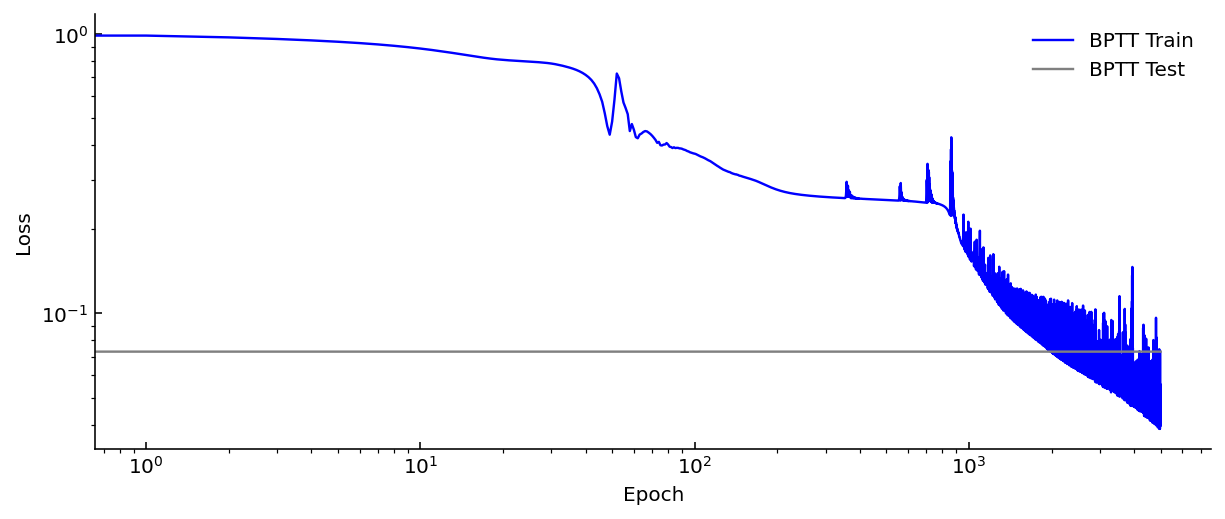

In [13]:
# Predict
test_inp = torch.from_numpy(test_X).type(torch.float)
test_out = torch.from_numpy(test_Y).type(torch.float)

test_inp.requires_grad = True
test_out.requires_grad = True

pred, rnn_output = net_trained(test_inp)

# Compute Loss
loss_test = criterion(pred[wash_out:,:,:], test_out[wash_out:,:,:]).detach().numpy()
print(loss_test)

plot_loss_history(loss_train, loss_test, None)

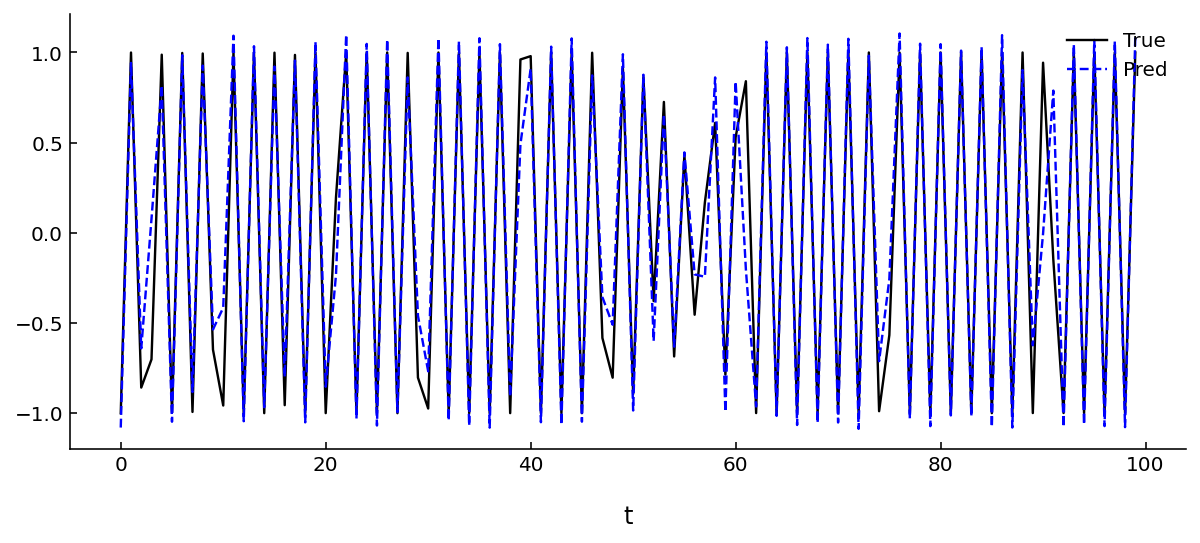

In [14]:
def plot_time_series(true, pred):
    fig = plt.figure(figsize=(10,4))
    ax = fig.add_subplot(111)
    stylize_axes(ax)
    ax.plot(true, label="True", linestyle='solid', color='black', linewidth=1.2)
    ax.plot(pred, label="Pred", linestyle='dashed', color='blue', linewidth=1.2)
    ax.set_xlabel("t", fontsize=12, labelpad=15)
    ax.legend(loc="upper right", frameon=False)
    plt.show()

index_to_plot = 0
plot_time_series(test_out[wash_out:,index_to_plot,0].detach().numpy(), pred[wash_out:,index_to_plot,0].detach().numpy())

## Extract the Lyapunov Exponents

Lyapunov exponent or Lyapunov characteristic exponent of a dynamical system is a quantity that characterizes the rate of separation of infinitesimally close trajectories.

<img src="figures/stability-and-chaos.png" width="700">

Lyapunov spectrum is given by the log of eigenvalues of Oseledets matrix
$$\large
\Lambda = \lim_{t\to\infty} [T_t^T T_t]^{1/2t}
$$

The analytical approximation of which is given by the long-term Jacobian product of non-commuting matrices
$$\large
T_t(h_0) = D_{t-1}(h_{t-1})...D_1(h-1)D_0(h_0)
$$

This is done by unrolling the network dynamics in time
$$\normalsize
\begin{align*}
    \frac{\partial L_t}{\partial W} &= \frac{\partial L_t}{\partial y_t}\frac{\partial y_t}{\partial h_t}\frac{\partial h_t}{\partial W} 
    \\
    &= \frac{\partial L_t}{\partial y_t}\frac{\partial y_t}{\partial h_t}
    \bigg[
        \frac{\partial^+ h_t}{\partial W} + \frac{\partial h_t}{\partial h_{t-1}}\frac{\partial^+h_{t-1}}{\partial W} + ... T_{t-1}(t)\frac{\partial^+ h_1}{\partial W}
    \bigg]
    \\
   T_t(t) &= \frac{\partial h_t}{\partial h_{t-1}}\frac{\partial h_{t-1}}{\partial h_{t-2}}...\frac{\partial h_{t-\tau+1}}{\partial h_{t-\tau}}
\end{align*}
$$

The RNN update equation is given by,

$$\large
h_t=tanh(W_{ih}\cdot  x_t+b_{ih}+W_{hh}\cdot h_{t−1}+b_{hh})$$

where the Jacobian is given by,

$$\normalsize
\begin{align*}
\frac{\partial h_{t+1,i}}{\partial h_{t,j}} &= w_{i,j} (1-tanh^2(h_{t+1,i})) \\
\frac{\partial h_{t+1}}{\partial h_t} &= W_{hh} diag(1-tanh^2(h_{t+1}))
\end{align*}
$$

Since pre-multiplying a matrix $A$ by a diagonal matrix $diag(k)$ is equivalent to scaling up row $i$ of matrix $A$ by $k$

In [15]:
def spectral_normalization(W, threshold=0.9):
    eigen_values = torch.linalg.eigvals(W)
    spectral_radius = max(abs(eigen_values))
    if spectral_radius > threshold:
        W = W/max(abs(eigen_values))
    return W

def jacobian(network, x, rnn_state):
    """Compute the Jacobian of an RNN state vector h(t+1) with respect to h(t) for each t."""
    jac_stacked = []
    hidden = rnn_state[-1]
    feed_seq = x.shape[0]
    
    for t in range(feed_seq):
        hidden = network.rnn.recurrence(x[t], hidden)
        W_hh = network.rnn.h2h.weight
        W_diag = torch.diag(1-torch.tanh(torch.pow(torch.flatten(hidden),2)))

        jac_t = torch.matmul(W_hh, W_diag)  # [N, N]
        jac_stacked.append(jac_t)

    # Stack together output from all time steps
    return torch.stack(jac_stacked)

In [26]:
feed_seq = 100
sample_id = 0

# Long-term Jacobian for the filter coefficients
_, rnn_state = net(test_inp[0:wash_out,sample_id:sample_id+1,:])
jac_stacked_filter = jacobian(net, test_inp[wash_out:wash_out+feed_seq,sample_id:sample_id+1,:], rnn_state)

# Long-term Jacobian for the bptt-rnn
_, rnn_state = net_trained(test_inp[0:wash_out,sample_id:sample_id+1,:])
jac_stacked_bptt = jacobian(net_trained, test_inp[wash_out:wash_out+feed_seq,sample_id:sample_id+1,:], rnn_state)

In [27]:
from scipy import linalg

def extract_eigen_values(M):
    eW = np.linalg.eigvals(M)
    rea = [n.real for n in eW]
    imag = [n.imag for n in eW]
    return rea, imag

def log(x):
	return np.array([cmath.log(xx) for xx in x])

def extract_lyapunov_exponents(jac_stacked, feed_seq, mode='LOG'):
    if mode == 'LOGARITHMIC':
        jac_cumulative = linalg.expm(sum([linalg.logm(jac_t.detach().numpy(), False)[0] for jac_t in jac_stacked])/feed_seq)
        return extract_eigen_values(jac_cumulative)

    if mode == 'CUMULATIVE':
        jac_cumulative = jac_stacked[0].detach().numpy()
        for jac_t in jac_stacked[1:]:
            jac_t = jac_t.detach().numpy()
            jac_cumulative = np.matmul(jac_cumulative, jac_t)
        return extract_eigen_values(jac_cumulative)

    if mode == 'FRACTIONAL_ROOT':
        jac_cumulative = jac_stacked[0].detach().numpy()
        for jac_t in jac_stacked[1:]:
            jac_t = jac_t.detach().numpy()
            jac_cumulative = np.matmul(jac_cumulative, jac_t)
        return extract_eigen_values(linalg.fractional_matrix_power(jac_cumulative, 1./feed_seq))
        
    # Calculate the spectrum of Lyapunov exponents by applying a QR-decomposition on the parallelepiped matrix N times. Return the spectrum sorted from maximum to minimum.
    if mode == 'QR_DECOMPOSITION':
        rvals = np.zeros((feed_seq, jac_stacked[0].shape[0]), dtype=np.complex128)
        # jac_cumulative = jac_stacked[0].detach().numpy()
        jac_cumulative = np.eye(jac_stacked[0].shape[0])
        lyapunov_exponents = np.zeros(jac_stacked[0].shape[0], dtype=np.complex128)
        for t in range(feed_seq):
            jac_t = jac_stacked[t].detach().numpy()
            jac_cumulative = np.matmul(jac_t, jac_cumulative)
            jac_cumulative, R = linalg.qr(jac_cumulative)
            r = log(np.abs(np.diag(R)))
            rvals[t,:] = r
            lyapunov_exponents += r
        lyapunov_exponents /= feed_seq
        return lyapunov_exponents, rvals
        
    if mode == 'DISCRETE_LEs':
        return None

In [18]:
W_filter, rvals_filter = extract_lyapunov_exponents(jac_stacked_filter, feed_seq, 'QR_DECOMPOSITION')
W_bptt, rvals_bptt = extract_lyapunov_exponents(jac_stacked_bptt, feed_seq, 'QR_DECOMPOSITION')

## Visualize Lyapunov Exponents

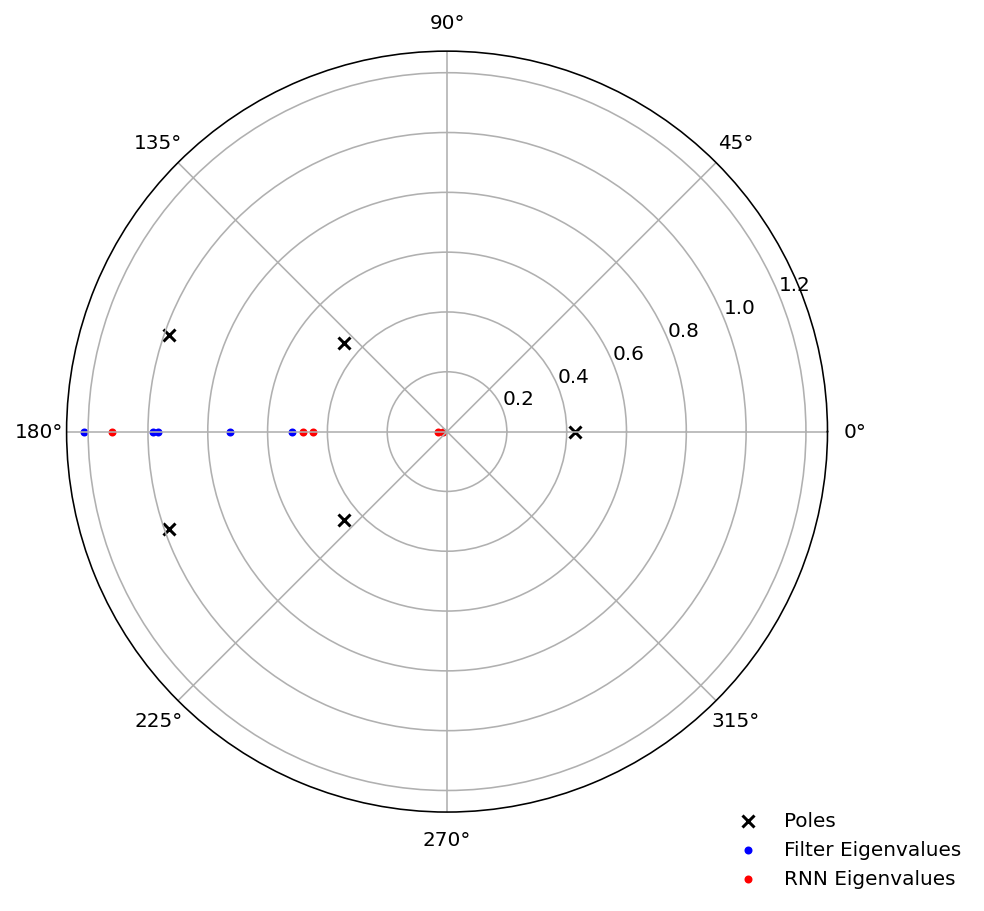

In [19]:
real_poles, imag_poles = [x.real for x in p], [x.imag for x in p]
realW_filter, imagW_filter = [n.real for n in W_filter], [n.imag for n in W_filter]
realW_bptt, imagW_bptt = [n.real for n in W_bptt], [n.imag for n in W_bptt]

polar_plot(real_poles, imag_poles, realW_filter, imagW_filter, realW_bptt, imagW_bptt)

In [20]:
import warnings
warnings.filterwarnings('ignore')

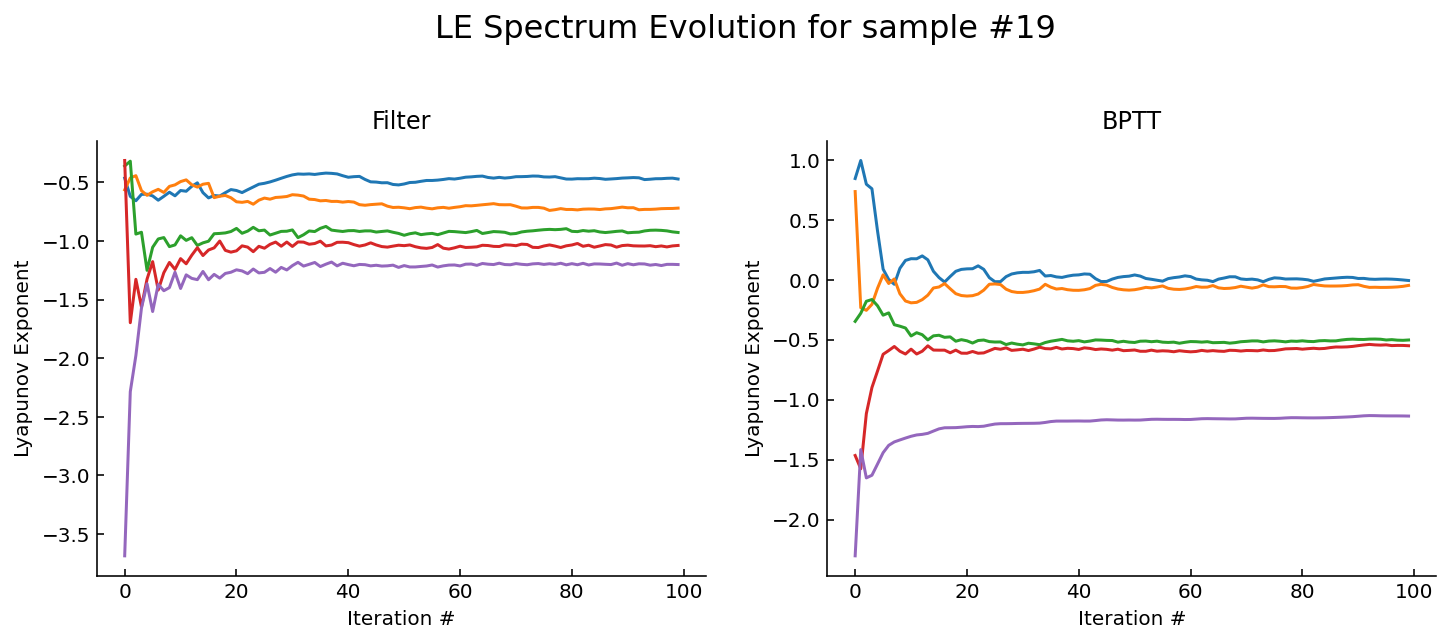

In [66]:
def plot_evolution(rvals_filter, rvals_bptt):
    fig = plt.figure(figsize=(12,4))
    ax1 = fig.add_subplot(121)
    stylize_axes(ax1)
    feed_seq = rvals_filter.shape[0]
    for i in range(rvals_filter.shape[1]):
        ax1.plot(np.divide(np.cumsum(rvals_filter[:,i], axis=0), np.arange(1., feed_seq+1)))
    ax1.set_xlabel('Iteration #')
    ax1.set_ylabel('Lyapunov Exponent')
    ax1.set_title('Filter')

    ax2 = fig.add_subplot(122)
    stylize_axes(ax2)
    feed_seq = rvals_bptt.shape[0]
    for i in range(rvals_bptt.shape[1]):
        ax2.plot(np.divide(np.cumsum(rvals_bptt[:,i], axis=0), np.arange(1., feed_seq+1)))
    ax2.set_xlabel('Iteration #')
    ax2.set_ylabel('Lyapunov Exponent')
    ax2.set_title('BPTT')

    plt.suptitle('LE Spectrum Evolution for sample #'+ str(sample_id), fontsize=16, y=1.1)
    plt.show()

plot_evolution(rvals_filter, rvals_bptt)

In [44]:
les_filter = np.zeros((test_inp.shape[1], W_filter.shape[0]), dtype=np.complex128)
les_bptt = np.zeros((test_inp.shape[1], W_bptt.shape[0]), dtype=np.complex128)

for sample_id in range(test_inp.shape[1]):
    # Long-term Jacobian for the filter coefficients
    _, rnn_state = net(test_inp[0:wash_out,sample_id:sample_id+1,:])
    jac_stacked_filter = jacobian(net, test_inp[wash_out:wash_out+feed_seq,sample_id:sample_id+1,:], rnn_state)
    W_filter, _ = extract_lyapunov_exponents(jac_stacked_filter, feed_seq, 'QR_DECOMPOSITION')
    les_filter[sample_id,:] = [n.real for n in W_filter]

    # Long-term Jacobian for the bptt-rnn
    _, rnn_state = net_trained(test_inp[0:wash_out,sample_id:sample_id+1,:])
    jac_stacked_bptt = jacobian(net_trained, test_inp[wash_out:wash_out+feed_seq,sample_id:sample_id+1,:], rnn_state)
    W_bptt, _ = extract_lyapunov_exponents(jac_stacked_bptt, feed_seq, 'QR_DECOMPOSITION')
    les_bptt[sample_id,:] = [n.real for n in W_bptt]

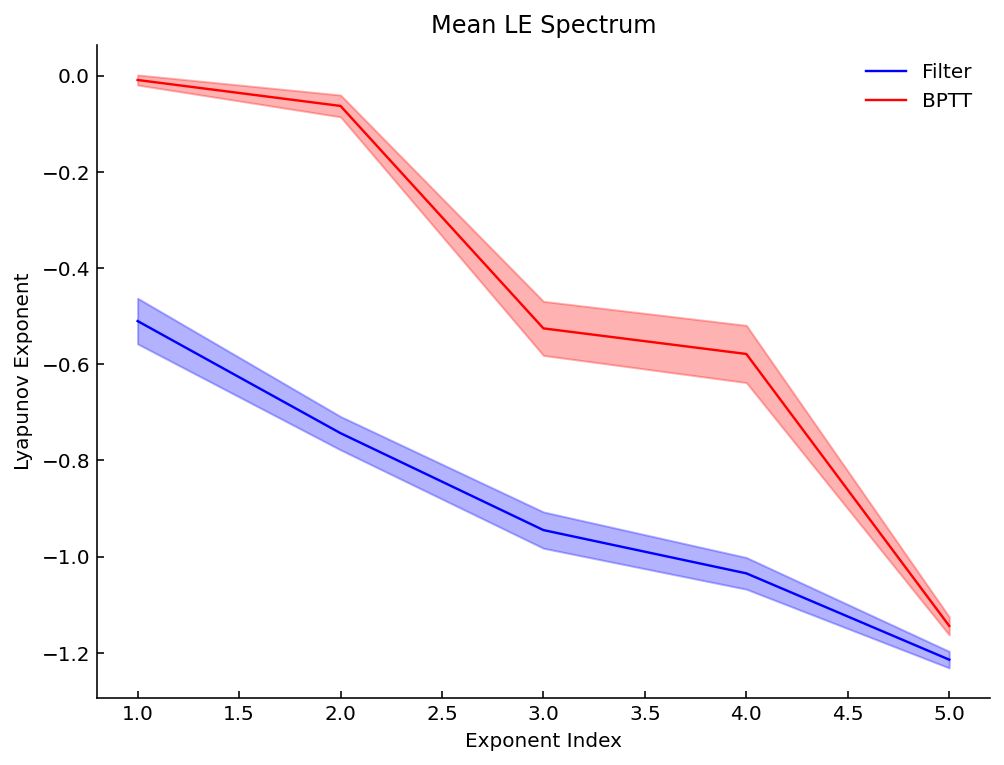

In [67]:
def LE_stats(LE):
    mean, std = (np.mean(LE, axis=0), np.std(LE, axis=0))
    return mean, std

def plot_spectrum(les_filter, les_bptt):
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111)
    stylize_axes(ax)

    feed_seq = les_filter.shape[1]
    x = range(1, feed_seq+1) 
    LE_mean, LE_std = LE_stats(les_filter)
    ax.plot(x, LE_mean, color='blue', ls='-', lw=1.2, label='Filter')
    ax.fill_between(x, LE_mean-LE_std, LE_mean+LE_std, color='blue', alpha=0.3)

    feed_seq = les_bptt.shape[1]
    x = range(1, feed_seq+1) 
    LE_mean, LE_std = LE_stats(les_bptt)
    ax.plot(x, LE_mean, color='red', ls='-', lw=1.2, label='BPTT')
    ax.fill_between(x, LE_mean-LE_std, LE_mean+LE_std, color='red', alpha=0.3)

    ax.set_xlabel('Exponent Index')
    ax.set_ylabel('Lyapunov Exponent')
    plt.title('Mean LE Spectrum')

    ax.legend(frameon=False)
    plt.show()

plot_spectrum(les_filter, les_bptt)

## Visualize the eigenvalue drift cross timesteps

In [ ]:
W_filter_stacked = extract_eigen_values(jac_stacked_filter.detach().numpy())
W_bptt_stacked = extract_eigen_values(jac_stacked_bptt.detach().numpy())

plot_polar_animation(real_poles, imag_poles, W_filter_stacked[0], W_filter_stacked[1], W_bptt_stacked[0], W_bptt_stacked[1], feed_seq)

## Correlation between Lyapunov Spectra and Peformance

In [ ]:
# TODO: Plot the performance correlation for the filter and bptt methods.

# Supplementary Material

## Compare against Target FT

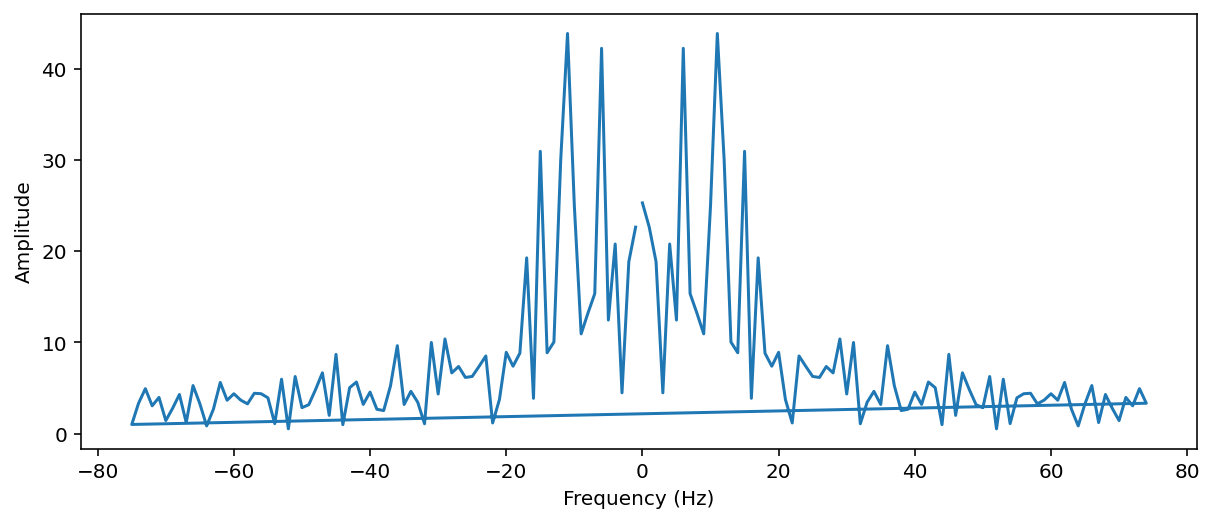

In [ ]:
from scipy import fftpack

fft = fftpack.fft(output)

amplitude = abs(fft)
power = amplitude**2
angle = np.angle(fft)

peak_amplitude_index = np.argmax(abs(fft))

sample_freq = fftpack.fftfreq(len(output), d=1/seq_len)
peak_amplitude_freq = sample_freq[peak_amplitude_index]

fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(111)
ax.plot(sample_freq, abs(fft))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.show()

In [ ]:
# print(realW_bptt, imagW_bptt)
# print(imagW_bptt[0]/(2*np.pi))